### Importamos Librerias y seteamos directorio/device a utilizar

In [67]:
import os, random,re, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from sentence_transformers import SentenceTransformer
from torch_geometric.transforms import RandomLinkSplit
import json
from sklearn.preprocessing import MultiLabelBinarizer
from torch_geometric.nn import HGTConv
from torch_geometric.nn import Linear
import matplotlib.pyplot as plt


In [2]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\mosca\Documents\Maestria\Tercer_trimestre\AA2\TP_AA2\tp_yelp


In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


### Carga de reviews Inicial

Esto debe correrse solo si se modifica el subconjunto de datos utilizados, saltear al siguiente paso si ya se ha realizado. Para facilitar correr el script completo, una de las celdas se ha comentado y debe quitarse los # en caso de que correrlo sea necesario

In [4]:
def cargar_reviews(current_dir,nombre_archivo="review_philadelphia.json"):

    """
    Carga un archivo de reseñas JSON y devuelve un df de pandas.
    """
    path = os.path.join(current_dir, "yelp_dataset", nombre_archivo)
    print(f"Leyendo archivo desde: {path}")

        
    reviews = []
    _word_re = re.compile(r"[A-Za-z0-9]+", re.UNICODE)
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):

            # ### Solo para empezar a trabajar la data
            # if i >= 100:   # detener después de 'limit' líneas
            #     break

            line = line.strip()
            if line:  # ignora líneas vacías
                dicc=json.loads(line)
                
                #para evitar tener reviews vacias
                if len(_word_re.findall(dicc['text'])) == 0: 
                    continue

                # nos quedamos con la data que queremos
                for key in ['review_id','funny','cool','useful','date']:
                    del dicc[f'{key}']
                reviews.append(dicc)
    
    print(f"Se cargaron {len(reviews)} reseñas desde {path}")


    rv_df = pd.DataFrame(reviews)
    # Convertir stars a int
    rv_df["stars"] = rv_df["stars"].astype(int)
    # Restar 1 para que queden entre 0 y 4
    rv_df["stars"] = rv_df["stars"] - 1

    return rv_df

In [5]:
# reviews=cargar_reviews(current_dir)
# reviews.head()
# model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
# embeddings = model.encode(reviews['text'], convert_to_tensor=True, show_progress_bar=True)
# embeddings_np = embeddings.cpu().numpy()
# reviews['embedding'] = list(embeddings_np)
# path = os.path.join(current_dir, "yelp_dataset", 'reviews_con_embeddings.pkl')
# print(f"Guardando archivo como: {path}")
# reviews.to_pickle(path)


### Carga de data de Usuarios y Locales

In [6]:
business = []
with open(os.path.join(current_dir, "yelp_dataset", "business_philadelphia.json"), "r", encoding="utf-8") as f:
    for line in f:
        business.append(json.loads(line))

df_business = pd.DataFrame(business)

users = []
with open(os.path.join(current_dir, "yelp_dataset", "user_philadelphia.json"), "r", encoding="utf-8") as f:
    for line in f:
        users.append(json.loads(line))

df_users = pd.DataFrame(users)

A partir de la columna de categorías de cada negocio, primero limpiamos los valores nulos y convertimos el texto en una lista de categorías individuales. Luego usamos MultiLabelBinarizer para transformar esas listas en vectores binarios: cada vector tiene un 1 en las posiciones que corresponden a las categorías del negocio y 0 en el resto. Finalmente, guardamos esos vectores en la columna category_vector del DataFrame.

In [ ]:
df_business['categories'] = df_business['categories'].fillna('')
df_business['categories_list'] = df_business['categories'].apply(
    lambda x: [c.strip() for c in x.split(',') if c.strip() != '']
)

mlb = MultiLabelBinarizer()
mlb.fit(df_business['categories_list'])
category_vectors = mlb.transform(df_business['categories_list'])

df_business['category_vector'] = list(category_vectors)

In [8]:
df_business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,categories_list,category_vector
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Restaurants, Food, Bubble Tea, Coffee & Tea, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...","[Sushi Bars, Restaurants, Japanese]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...","[Korean, Restaurants]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...","[Cocktail Bars, Bars, Italian, Nightlife, Rest...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1...","[Pizza, Restaurants, Salad, Soup]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14564,wPAaAbFbq5wfLfW0gnYU7g,Intermix,1718 Walnut St,Philadelphia,PA,19103,39.950060,-75.170129,2.0,10,0,"{'BusinessParking': '{'garage': False, 'street...","Fashion, Shopping, Women's Clothing","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...","[Fashion, Shopping, Women's Clothing]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14565,JDM7kiCEmeBc_5W-z6eZZw,2601 Parkway Apartments,2601 Pennsylvania Ave,Philadelphia,PA,19130,39.968806,-75.180608,3.0,6,1,{'BusinessAcceptsCreditCards': 'True'},"Real Estate, Apartments, Home Services",None,"[Real Estate, Apartments, Home Services]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14566,9U1Igcpe954LoWZRmNc-zg,Hand & Stone Massage And Facial Spa,"1100 S Columbus Blvd, Ste 24",Philadelphia,PA,19147,39.932756,-75.144504,3.0,32,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Day Spas, Beauty & Spas, Skin Care, Massage","{'Monday': '9:0-22:0', 'Tuesday': '9:0-22:0', ...","[Day Spas, Beauty & Spas, Skin Care, Massage]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14567,LJ4GjQ1HL6kqvIPpNUNNaQ,Shanti Yoga and Ayurveda,"1638 Pine St, Fl 1",Philadelphia,PA,19103,39.945966,-75.169666,4.5,39,1,"{'ByAppointmentOnly': 'True', 'GoodForKids': '...","Health & Medical, Yoga, Shopping, Naturopathic...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Health & Medical, Yoga, Shopping, Naturopathi...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
df_business.describe()

,latitude,longitude,stars,review_count,is_open
count,14569.000000,14569.000000,14569.000000,14569.000000,14569.000000
mean,39.976458,-75.152681,3.623035,64.262475,0.723591
std,0.049547,0.053926,0.960691,165.301869,0.447237
min,39.864924,-75.651673,1.000000,5.000000,0.000000
25%,39.948050,-75.175764,3.000000,9.000000,0.000000
50%,39.954384,-75.161018,4.000000,19.000000,1.000000
75%,40.008115,-75.143919,4.500000,53.000000,1.000000
max,40.247267,-74.893799,5.000000,5721.000000,1.000000


In [10]:
df_users.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000,279855.00000,279855.000000,279855.000000,279855.000000,279855.000000,279855.000000
mean,38.949202,86.047911,36.994701,52.161941,3.010802,3.663550,3.978382,0.629991,0.446324,0.321867,0.191753,3.22964,6.517514,6.091937,6.091937,2.282289,2.892812
std,143.873461,1166.512581,790.558723,1034.276860,36.159287,1.091632,131.998451,29.665142,33.881293,27.452695,25.237755,146.76918,241.252855,174.518699,174.518699,60.483120,213.486556
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,3.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,5.000000,1.000000,1.000000,0.000000,3.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24.000000,21.000000,4.000000,5.000000,1.000000,4.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17473.000000,206296.000000,185823.000000,199878.000000,12497.000000,5.000000,25784.000000,13501.000000,14180.000000,13654.000000,12669.000000,59031.00000,101097.000000,49967.000000,49967.000000,15934.000000,82630.000000


### Carga de datos de review pre-calculados

In [11]:
path = os.path.join(current_dir, "yelp_dataset", 'reviews_con_embeddings.pkl')
reviews_cargados = pd.read_pickle(path)

In [12]:
reviews_cargados.describe()

,stars
count,967506.000000
mean,2.785678
std,1.388202
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


Consideramos como usuarios activos a aquellos con mas de dos reviews, por lo tanto, nos quedaremos solo con sus opiniones para crear el grafo

In [13]:
MIN_REVIEWS = 2

user_counts = reviews_cargados['user_id'].value_counts()
valid_users = user_counts[user_counts >= MIN_REVIEWS].index

df_filtrado = reviews_cargados[reviews_cargados['user_id'].isin(valid_users)].reset_index(drop=True)
unique_reviews = reviews_cargados[~reviews_cargados['user_id'].isin(valid_users)].reset_index(drop=True)

reviews_cargados=df_filtrado

In [14]:
reviews_cargados.describe()

,stars
count,801541.000000
mean,2.829345
std,1.314086
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


### Preparamos la data para la contruccion del grafo

In [ ]:
# Cargamos los embeddings de reseñas
embeddings_car_np = np.stack(reviews_cargados['embedding'].values)
edge_embeddings = torch.from_numpy(embeddings_car_np)

Creamos grafo heterogeneo donde los usuarios y lugares son dos tipos de nodos diferentes unidos por reseñas, representadas como aristas unidireccionales

In [ ]:
# Mapeo de IDs unicos a indices y los utilizamos dicho mapeo para obtener los indices de las reseñas
user_mapping = {id: i for i, id in enumerate(reviews_cargados['user_id'].unique())}
place_mapping = {id: i for i, id in enumerate(reviews_cargados['business_id'].unique())}

user_indices_mapped = reviews_cargados['user_id'].map(user_mapping)
place_indices_mapped = reviews_cargados['business_id'].map(place_mapping)


# Preparamos esqueleto del grafo
NUM_NODES_USER = len(user_mapping) 
NUM_NODES_PLACE = len(place_mapping)
NUM_RATINGS = reviews_cargados.shape[0]

data = HeteroData()
data['user'].num_nodes = NUM_NODES_USER
data['place'].num_nodes = NUM_NODES_PLACE

# Datos para las aristas
ratings = reviews_cargados['stars']

# Convertimos series de pandas a tensores de PyTorch antes de apilarlas

data['user', 'rates', 'place'].edge_index = torch.stack([
    torch.from_numpy(user_indices_mapped.values).long(),
    torch.from_numpy(place_indices_mapped.values).long()
], dim=0)

# Agragamos label de buena arista a todas aquellas reseñas con rating mayor a 3
data['user', 'rates', 'place'].edge_attr_label  = torch.from_numpy((ratings > 3).values).long()

# Cargamos embedding de reseña a la arista
data['user', 'rates', 'place'].edge_attr = edge_embeddings

Añadimos el ID original a cada nodo. El mismo es un string y no se utilizara para el entrenamiento/prediccion

In [18]:
inv_user = [None] * NUM_NODES_USER
for uid, idx in user_mapping.items():
    inv_user[idx] = uid

data['user'].id = inv_user

inv_place = [None] * NUM_NODES_PLACE
for bid, idx in place_mapping.items():
    inv_place[idx] = bid

data['place'].id = inv_place

In [ ]:
df_business

# Filtrar df_business para quedarnos solo con los negocios presentes en place_mapping
df_business_filtrado = df_business[df_business['business_id'].isin(place_mapping.keys())]

# Reordenamos segun el orden en place_mapping
df_business_filtrado = df_business_filtrado.set_index('business_id')
df_business_ordenado = df_business_filtrado.loc[place_mapping.keys()] 

# Tomamos los vectores de categoria de cada lugar y los asiganmos como atributos en el grafo
business_vec_np = np.stack(df_business_ordenado['category_vector'].values)
business_Vec = torch.from_numpy(business_vec_np).float()

data['place'].x = business_Vec

In [20]:
print(f"Forma del edge_attr: {data['user', 'rates', 'place'].edge_attr_label.shape}")
print(f"Forma del atributos de business: {data['place'].x.shape}")

Forma del edge_attr: torch.Size([801541])
Forma del atributos de business: torch.Size([14534, 1027])


In [21]:
data

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 801541],
    edge_attr_label=[801541],
    edge_attr=[801541, 384],
  }
)

### Dividimos la data en conjunto de entrenamiento, validacion y testeo

Esta division creara conjuntos con distintas reseñas (aristas) para cada subset

In [22]:
transform = RandomLinkSplit(
    num_val=0.1, num_test=0.1, is_undirected=False,
    edge_types=[('user', 'rates', 'place')],
    add_negative_train_samples= False
)
train_data_raw, val_data_raw, test_data_raw = transform(data)

In [23]:
train_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  }
)

In [24]:
val_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[160308],
    edge_label_index=[2, 160308],
  }
)

Creamos los 'vectores de categoria' para los usuarios en base a los lugares que visitaron (calculado como el promedio de los vectores de los mismos)

In [ ]:
def compute_user_vectors(data):
    edge_index = data['user', 'rates', 'place'].edge_index
    place_vecs = data['place'].x  
    
    num_users = data['user'].num_nodes
    dim = place_vecs.size(1)

    # Inicializamos un acumulador y un contador
    user_sum = torch.zeros((num_users, dim))
    user_count = torch.zeros(num_users)

    # Descomponemos aristas
    user_idx = edge_index[0]
    place_idx = edge_index[1]

    # Sumamos vectores de lugares visitados
    user_sum.index_add_(0, user_idx, place_vecs[place_idx])
    user_count.index_add_(0, user_idx, torch.ones_like(user_idx, dtype=torch.float))

    # Promediamos, evitando divisiones por cero
    user_mean = user_sum / user_count.clamp(min=1).unsqueeze(1)

    return user_mean

In [26]:
train_user_vec = compute_user_vectors(train_data_raw)
val_user_vec   = compute_user_vectors(val_data_raw)
test_user_vec  = compute_user_vectors(test_data_raw)

In [ ]:
train_data_raw['user'].x = train_user_vec
val_data_raw['user'].x   = val_user_vec
test_data_raw['user'].x  = test_user_vec


Creamos las aristas en direccion apuesta

In [ ]:
train_data_raw = T.ToUndirected()(train_data_raw)
val_data_raw = T.ToUndirected()(val_data_raw)
test_data_raw = T.ToUndirected()(test_data_raw)

In [28]:

train_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
    x=[113872, 1027],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
  }
)

In [29]:

val_data_raw

HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
    x=[113872, 1027],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1027],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[160308],
    edge_label_index=[2, 160308],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
  }
)

Para añadir la informacion de las reseñas a los atributos de los nodos, contanamos el promedio de los vectores semanticos de las reseñas de cada usuario y de cada lugar al final de los vectores de categoria de cada uno.

In [30]:
def scatter_mean_torch(src, index, dim_size):


    out = torch.zeros(dim_size, src.size(1), device=src.device)
    out = out.index_add(0, index, src)

    # contadores por nodo
    count = torch.zeros(dim_size, device=src.device).index_add(0, index, torch.ones(src.size(0), device=src.device))

    # evitar división por cero
    count = count.clamp(min=1).unsqueeze(1)

    return out / count


def vec_aristas(data_input):
    data = data_input

    # Edges user → place
    src = data["user", "rates", "place"].edge_index[0]  
    edge_attr = data["user", "rates", "place"].edge_attr 
    user_review_mean = scatter_mean_torch(edge_attr, src, dim_size=data['user'].num_nodes)

    # Edges place → user
    src_p = data["place", "rev_rates", "user"].edge_index[0]  # places
    edge_attr_p = data["place", "rev_rates", "user"].edge_attr  # [774006, 384]
    place_review_mean = scatter_mean_torch(edge_attr_p, src_p, dim_size=data['place'].num_nodes)

    # Concatenar a las features de usuario
    data['user'].x = torch.cat([data['user'].x, user_review_mean], dim=1)
    data['place'].x = torch.cat([data['place'].x, place_review_mean], dim=1)

    return data


In [31]:
train_data_raw=vec_aristas(train_data_raw)
val_data_raw=vec_aristas(val_data_raw)
test_data_raw=vec_aristas(test_data_raw)

In [32]:

train_data_raw


HeteroData(
  user={
    num_nodes=113872,
    id=[113872],
    x=[113872, 1411],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1411],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
  }
)

Como ultimo paso en la creacion del grafo, recuperaremos los Usuarios con una sola review para utilizarlos como caso de analisis 'Cold Start' en el futuro

In [ ]:
#Obtenemos la cantidad de nodos a agg
users_unique_review=unique_reviews['user_id'].unique()
N=len(users_unique_review)

#Obtenemos sus atributos (vector de categoria + vector semantico)

business_ids_unique = unique_reviews['business_id'].unique()
df_business_unique = df_business[df_business['business_id'].isin(business_ids_unique)]

df_merged = df_business_unique.merge(
    unique_reviews[['business_id', 'embedding']],
    on='business_id',
    how='inner'
)

category_vecs = np.stack(df_merged['category_vector'].values)
review_embeddings = np.stack(df_merged['embedding'].values)


user_final_features_np = np.concatenate([category_vecs, review_embeddings], axis=1)
user_final_features = torch.from_numpy(user_final_features_np).float()

# Convertir los user_id nuevos a lista
new_user_ids = list(users_unique_review)


No es necesario agg los IDs a todos los subconjuntos porque son lo mismo (se puede probar con train_data_raw['user'].id is val_data_raw['user'].id)

In [35]:
train_data_raw['user'].x = torch.cat([train_data_raw['user'].x, user_final_features], dim=0)
train_data_raw['user'].num_nodes += N
train_data_raw['user'].id.extend(new_user_ids)

In [36]:
val_data_raw['user'].x = torch.cat([val_data_raw['user'].x, user_final_features], dim=0)
val_data_raw['user'].num_nodes += N

In [37]:
test_data_raw['user'].x = torch.cat([test_data_raw['user'].x, user_final_features], dim=0)
test_data_raw['user'].num_nodes += N

In [38]:
train_data_raw

HeteroData(
  user={
    num_nodes=279837,
    id=[279837],
    x=[279837, 1411],
  },
  place={
    num_nodes=14534,
    id=[14534],
    x=[14534, 1411],
  },
  (user, rates, place)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
    edge_label_index=[2, 641233],
  },
  (place, rev_rates, user)={
    edge_index=[2, 641233],
    edge_attr_label=[641233],
    edge_attr=[641233, 384],
    edge_label=[641233],
  }
)

### Creacion del modelo

Creamos nuestro modelo usando capas HGTConv, que generan los embeddings de usuarios y lugares dentro de un grafo heterogéneo. La arquitectura funciona de manera similar a un two-tower con la diferencia de que, en vez de usar redes independientes, aprovechamos un transformer diseñado específicamente para grafos heterogéneos, que modela mejor las distintas relaciones y tipos de nodos.

Después, estas representaciones se combinan en un clasificador final que predice la interacción entre usuario y lugar.

In [ ]:

class HGTBinaryModel(nn.Module):
    def __init__(self, metadata, hidden_channels=128, heads=2):
        super().__init__()

        # Proyecciones iniciales para cada tipo de nodo
        self.node_emb = nn.ModuleDict()
        for node_type in metadata[0]:
            self.node_emb[node_type] = Linear(-1, hidden_channels)

        # Dos capas heterogéneas
        self.conv1 = HGTConv(
            in_channels={nt: hidden_channels for nt in metadata[0]},
            out_channels=hidden_channels,
            metadata=metadata,
            heads=heads
        )


        self.conv2 = HGTConv(
            in_channels={nt: hidden_channels for nt in metadata[0]},
            out_channels=hidden_channels,
            metadata=metadata,
            heads=heads
        )
        
        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Linear(4 * hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        self.out_layer = nn.Linear(hidden_channels + 4 * hidden_channels, 1)

    def encode_nodes(self, data):
        x_dict = {}
        
        for nt, x in data.x_dict.items():
            x_dict[nt] = self.node_emb[nt](x)

        h = self.conv1(x_dict, data.edge_index_dict)
        for nt in h:
            h[nt] = h[nt] + x_dict[nt]

        x_dict = h
        h = self.conv2(x_dict, data.edge_index_dict)
        for nt in h:
            h[nt] = h[nt] + x_dict[nt]

        return h
    
    def predict_edges(self, h, edge_label_index):

        user_idx, place_idx = edge_label_index
        u = h["user"][user_idx]
        p = h["place"][place_idx]

        edge_repr = torch.cat([u, p, u*p, torch.abs(u-p)], dim=1)
        h2 = self.classifier(edge_repr)
        h2 = torch.cat([h2, edge_repr], dim=1)
        logit = self.out_layer(h2).squeeze()
        return logit


In [ ]:
# Debemos enviar todo al mismo device para correr el modelo
train_data_raw = train_data_raw.to(device)
val_data_raw   = val_data_raw.to(device)
test_data_raw = test_data_raw.to(device)

In [41]:


# y_train = train_data_raw["user","rates","place"].edge_attr_label[train_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
# y_val   = val_data_raw["user","rates","place"].edge_attr_label[val_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
# y_test = test_data_raw["user","rates","place"].edge_attr_label[test_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)

# val_edge_index = val_data_raw["user", "rates", "place"].edge_label_index
# train_edge_index = train_data_raw["user", "rates", "place"].edge_label_index
# test_edge_index = test_data_raw["user", "rates", "place"].edge_label_index



In [42]:

# import gc

# del model
# del y_train
# del y_val
# del y_test

# gc.collect()
# torch.cuda.empty_cache()

# torch.cuda.synchronize()
# gc.collect()
# torch.cuda.empty_cache()

In [43]:
model = HGTBinaryModel(
    
    metadata=train_data_raw.metadata(),
    hidden_channels=128,
    heads=2
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


y_train = train_data_raw["user","rates","place"].edge_attr_label[train_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
y_val   = val_data_raw["user","rates","place"].edge_attr_label[val_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)
y_test = test_data_raw["user","rates","place"].edge_attr_label[test_data_raw["user","rates","place"].edge_label_index[1]].float().to(device)

# un desbalanceo en la clases nos estaba afectando el entraenamiento
pos_weight = torch.tensor([(1 - float(y_train.mean())) / float(y_train.mean())]).to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight,reduction = 'none')

In [44]:
epochs = 80
performance_acc=[]
performance_recall_neg = []

# Para correccion del popularity bias
place_degrees = torch.bincount(train_data_raw['user','rates','place'].edge_index[1], minlength=NUM_NODES_PLACE)
edge_place_indices = train_data_raw['user','rates','place'].edge_index[1]
weights_pop = 1.0 / torch.sqrt(place_degrees[edge_place_indices] + 1e-6)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    h_train = model.encode_nodes(train_data_raw) 
    logits_train = model.predict_edges(h_train, train_data_raw['user','rates','place'].edge_label_index)

    loss_raw  = loss_fn(logits_train, y_train)

    loss= (loss_raw * weights_pop).mean()

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        prob = torch.sigmoid(logits_train)
        pred = (prob > 0.5).long()
        correct = (pred == y_train.long()).sum().item()
        acc = correct / y_train.size(0)

        true_neg = ((pred == 0) & (y_train == 0)).sum().item()
        false_pos = ((pred == 1) & (y_train == 0)).sum().item()
        recall_neg = true_neg / (true_neg + false_pos + 1e-12)

    model.eval()
    with torch.no_grad():
        #Validation
        logits_val = model.predict_edges(h_train, val_data_raw['user','rates','place'].edge_label_index)
        val_prob = torch.sigmoid(logits_val)
        val_pred = (val_prob > 0.5).long()
        val_acc = (val_pred == y_val.long()).sum().item() / y_val.size(0)

        val_true_neg = ((val_pred == 0) & (y_val == 0)).sum().item()
        val_false_pos = ((val_pred == 1) & (y_val == 0)).sum().item()
        val_recall_neg = val_true_neg / (val_true_neg + val_false_pos + 1e-12)

        #testing
        logits_test = model.predict_edges(h_train, test_data_raw['user','rates','place'].edge_label_index)
        test_prob = torch.sigmoid(logits_test)
        test_pred = (test_prob > 0.5).long()
        test_acc = (test_pred == y_test.long()).sum().item() / y_test.size(0)

        test_true_neg = ((test_pred == 0) & (y_test == 0)).sum().item()
        test_false_pos = ((test_pred == 1) & (y_test == 0)).sum().item()
        test_recall_neg = test_true_neg / (test_true_neg + test_false_pos + 1e-12)

    a=[epoch,acc,val_acc,test_acc]
    r = [epoch, recall_neg, val_recall_neg, test_recall_neg]
    print(a,r)
    performance_acc.append(a)
    performance_recall_neg.append(r)

[0, 0.48361827915905764, 0.42456396436859045, 0.4245702023604561] [0, 0.4280261925053862, 0.027456013690571688, 0.029038867900364987]
[1, 0.5607867966870077, 0.4367218105147591, 0.4361791052224468] [1, 0.5028320514109968, 0.07419648109524574, 0.0750144073765768]
[2, 0.5925942676063147, 0.48602066022905904, 0.4851411033760012] [2, 0.5373724915170797, 0.28309535269265734, 0.28228853172824486]
[3, 0.6213638412246406, 0.5306534920278464, 0.5305536841579959] [3, 0.5953977841182791, 0.4721428953419969, 0.4726686730272566]
[4, 0.6369712725327611, 0.5395363924445442, 0.5391309229732765] [4, 0.6019220894716504, 0.4640355099203166, 0.4648886896757807]
[5, 0.6467882969217118, 0.554707188661826, 0.5531227387279487] [5, 0.5989894605339079, 0.48633616770950316, 0.48522977097607306]
[6, 0.6604775487225393, 0.5817114554482621, 0.5793098285799835] [6, 0.6181547729329995, 0.5824589550243329, 0.5787709974173444]
[7, 0.6770253558378936, 0.6116912443546174, 0.6100319385183521] [7, 0.6478701385323092, 0.721

Graficamos curva de accuaracy y de Recall

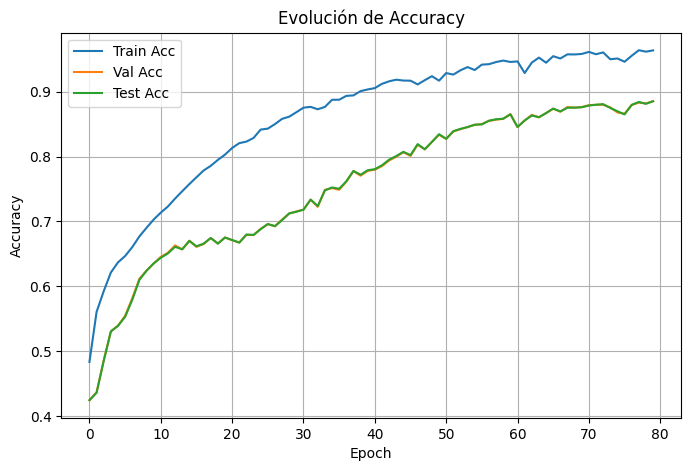

In [ ]:

# Convertir a array para indexar más fácil
perf = np.array(performance_acc)

epochs   = perf[:, 0]
train_acc = perf[:, 1]
val_acc   = perf[:, 2]
test_acc  = perf[:, 3]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.plot(epochs, test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución de Accuracy")
plt.legend()
plt.grid(True)

plt.show()

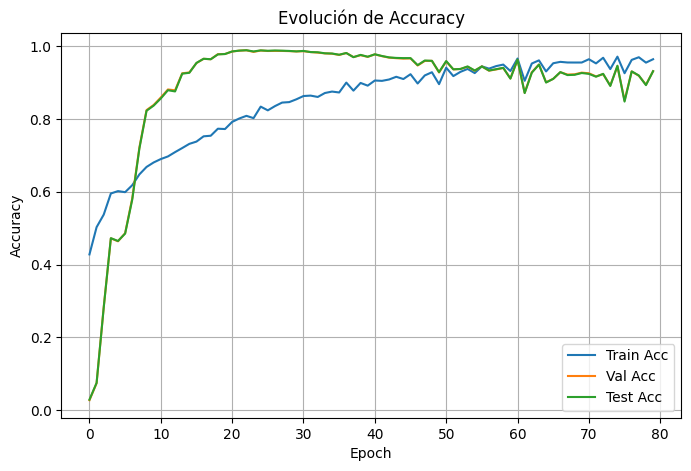

In [ ]:
# Convertir a array para indexar más fácil
perf = np.array(performance_recall_neg)

epochs   = perf[:, 0]
train_acc = perf[:, 1]
val_acc   = perf[:, 2]
test_acc  = perf[:, 3]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.plot(epochs, test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Evolución de Recall Negativo")
plt.legend()
plt.grid(True)

plt.show()

### Guardar modelo

In [47]:
path_model=os.path.join(current_dir, "modelo_yelp_philly2.pth")
torch.save(model.state_dict(), path_model)

### Cargar modelo y evaluar resultados

In [48]:
model1 = model = HGTBinaryModel(
    metadata=train_data_raw.metadata(),
    hidden_channels=128,
    heads=2
) 
model1.load_state_dict(torch.load("modelo_yelp_philly2.pth"))
model1.eval()
model1=model1.to(device)


In [64]:
# 1) Identificar el nuevo usuario
# new_user_id = NUM_NODES_USER+59
new_user_id=20
print(new_user_id)
num_places = train_data_raw['place'].num_nodes

# 2) Crear edge_label_index user_new → all places
user_nodes = torch.full((num_places,), new_user_id, dtype=torch.long)
place_nodes = torch.arange(num_places, dtype=torch.long)
edge_label_index_new = torch.stack([user_nodes, place_nodes], dim=0)

# 3) Encodear nodos
h = model1.encode_nodes(train_data_raw)

# 4) Predecir para TODOS los lugares
scores = model1.predict_edges(
    h,
    edge_label_index_new
)
prob = torch.sigmoid(scores)


#Otra parte apra combatir popularity bias
place_degrees = torch.bincount(train_data_raw['user','rates','place'].edge_index[1], minlength=NUM_NODES_PLACE)
alpha = 0.6
pop = place_degrees / place_degrees.max()
adjusted_prob = prob - alpha * pop



# 5) Top-K recomendaciones
K = 15
topk = torch.topk(adjusted_prob, K)
recommended_place_ids = topk.indices.tolist()
recommended_probs = topk.values.tolist()

print("=== Top K recomendaciones ===")
for rank, (pid, p) in enumerate(zip(recommended_place_ids, recommended_probs), start=1):
    print(f"{rank}. place_index={pid}  prob={p:.4f}")

20
=== Top K recomendaciones ===
1. place_index=2494  prob=0.9998
2. place_index=4316  prob=0.9998
3. place_index=4048  prob=0.9998
4. place_index=7223  prob=0.9998
5. place_index=11562  prob=0.9997
6. place_index=11259  prob=0.9997
7. place_index=12964  prob=0.9997
8. place_index=4164  prob=0.9996
9. place_index=4075  prob=0.9996
10. place_index=2823  prob=0.9996
11. place_index=1121  prob=0.9996
12. place_index=11474  prob=0.9996
13. place_index=7121  prob=0.9996
14. place_index=9580  prob=0.9996
15. place_index=1308  prob=0.9995


Ver lugares recomendados:

In [65]:
business_ids_from_graph = [train_data_raw['place'].id[i] for i in recommended_place_ids]
business_ids_from_graph

['XFu1Ya1voQvk5t-0oZhc5A',
 'qd6t6bkXt5CIEjJdWbYTsw',
 'X9rHylXdk7KEb-r4ByDmxw',
 'lxbY-WSj7V4Nj1w8AuNXUA',
 'GtC_ResrQIJid_WKLtrZeQ',
 'qz4q9Bx1yTTQyszX9SseKw',
 '9R2UVjlnijJBfjMitKpjzw',
 '3qVvyOk6a9uZDEeJB2FHRA',
 'rEwL8Wbm_Ym7p7GDVsE72A',
 'U0oG8NI9Fz5YqpPf12fNpg',
 '-tx2Fb2MWnEqiCmr23uOrQ',
 'iYcDcwUehtwBoIxOCfQZlA',
 'BnnX18SkiQuOUExbTIQErw',
 'jmogHrd-bZTZIadqWW7vRg',
 'htK289P8_5AhuTGM99tlUA']

In [66]:
df_recommended = (
    df_business[df_business['business_id'].isin(business_ids_from_graph)]
        .drop_duplicates(subset='business_id')
)

df_recommended[['name','address','city','latitude','longitude','categories']]

,name,address,city,latitude,longitude,categories
586,The Body Shop Center City,518 N 2nd St,Philadelphia,39.959805,-75.142042,"Automotive, Auto Detailing, Body Shops, Towing..."
1219,The Salvation Army,4555 Pechin St,Philadelphia,40.033619,-75.220251,"Donation Center, Local Services, Shopping, Thr..."
2300,Mastah Tee Fitness & Dance,714 Reed St,Philadelphia,39.931346,-75.157150,"Dance Studios, Active Life, Boot Camps, Fitnes..."
2910,Philly Injury Lawyer,"1500 John F Kennedy Blvd, Ste 550",Philadelphia,39.953402,-75.165723,"Medical Law, Lawyers, Workers Compensation Law..."
3421,Kremp Florist,18 Locust,Philadelphia,40.127863,-75.032135,"Florists, Flowers & Gifts, Shopping"
3468,Little Geniuses Academy,8012 Bustleton Ave,Philadelphia,40.060183,-75.052160,"Child Care & Day Care, Local Services"
4267,Aramark Corporation,1101 Market St,Philadelphia,39.952123,-75.158543,"Uniforms, Shopping"
4341,Liberty Art & Framing,136 S 20th St,Philadelphia,39.950831,-75.173898,"Florists, Shopping, Arts & Crafts, Framing, Fl..."
6536,She Sugars Co,"1204 E Palmer St, Unit 1",Philadelphia,39.971092,-75.128752,"Waxing, Beauty & Spas, Sugaring, Hair Removal"
6736,I95 Collision Center,7360 Wissinoming St,Philadelphia,40.026097,-75.029088,"Automotive, Windshield Installation & Repair, ..."


In [57]:
new_user_id_from_graph = train_data_raw['user'].id[new_user_id]
reviewed_business_id=reviews_cargados[ reviews_cargados['user_id'] == new_user_id_from_graph]['business_id']

df_reviewed = (
    df_business[df_business['business_id'].isin(reviewed_business_id)]
        .drop_duplicates(subset='business_id')
)
df_reviewed


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,categories_list,category_vector
418,C7ZNfxgDQWinNzRfTkevxg,The Men's Club Barber Shop,7617 Ridge Ave,Philadelphia,PA,19128,40.051324,-75.236085,4.5,62,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Barbers, Beauty & Spas","{'Monday': '9:0-17:30', 'Tuesday': '9:0-20:0',...","[Barbers, Beauty & Spas]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
